In [618]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [619]:
sns.set_style('darkgrid')
sns.set_palette("Blues_r")
sns.set(rc={'figure.figsize':(12,6)})
sns.set_context(rc={"axes.facecolor": ".9", "axes.titlesize":16,"axes.labelsize":15,})

In [620]:

def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

## Residuals

The differences between observer and predicted y-values are called residuals:

$$e_i = y_i - \hat{y}_i,{~}{~}{~}{~}{~}i=1,...,n$$

Residuals are used to check whether the use of regression is appropriate. The residual plot is a scatteplot of the residuals against the x-values. It should show an unstructured horizontal band.



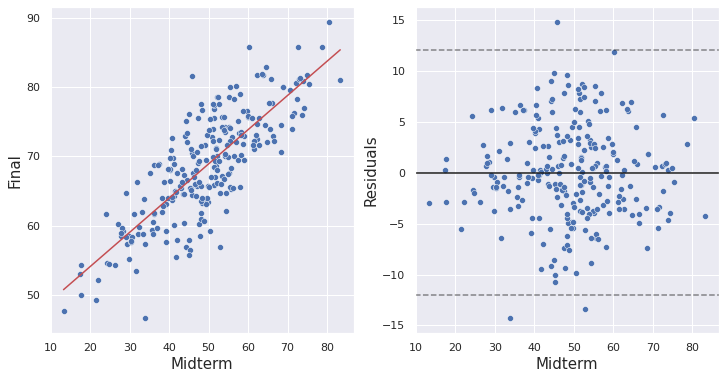

In [621]:

# Generate Data
dependency_nstd = np.array([
    [0.8, 0.8],
    [1, 0.2]
])
mu = 49.5, 69.1
scale = 10, 10

x, y = get_correlated_dataset(250, dependency_nstd, mu, scale)
data = pd.DataFrame.from_dict({'Final':y,'Midterm':x})

# Modeling
model = LinearRegression()
model.fit(data[['Midterm']], data[['Final']])
data['Predictions'] = model.predict(data[['Midterm']])
data['Residuals'] = data['Final'] - data['Predictions']

# Plot
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=data['Midterm'], y=data['Final'], ax=ax[0])
sns.lineplot(x=data['Midterm'], y=data['Predictions'], color='r', ax=ax[0])
sns.scatterplot(x=data['Midterm'], y=data['Residuals'], ax=ax[1])
ax[1].axhline(0, color='k')
ax[1].axhline(12, color='k', linestyle="--", alpha=0.5)
_ = ax[1].axhline(-12, color='k',linestyle="--", alpha=0.5)

A curved pattern suggests that the scatter is not linear:

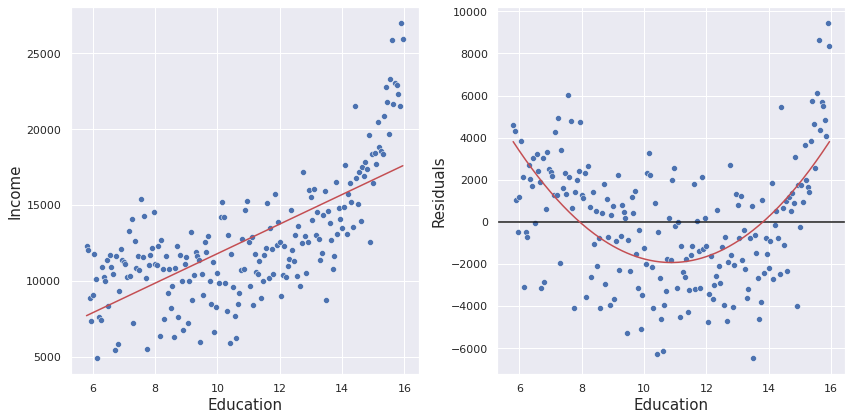

In [622]:

def GetPolyData(x):    
    return np.power(2,x/1.15) + np.random.normal(10000, 2000, len(x))

x = np.arange(5.8, 16, 0.05)
y = GetPolyData(x)
data = pd.DataFrame.from_dict({'Income':y,'Education':x})

# Create a linear model of the Data
model = LinearRegression()
model.fit(data[['Education']], data[['Income']])

# Make predictions to calculate the Residuals (y - ŷ)
data['Predictions'] = model.predict(data[['Education']])
data['Residuals'] = data['Income'] - data['Predictions']

# Plot data and residuals
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=data['Education'], y=data['Income'], ax=ax[0])
sns.lineplot(x=data['Education'], y=data['Predictions'], color='r', ax=ax[0])
sns.scatterplot(x=data['Education'], y=data['Residuals'], ax=ax[1])
ax[1].axhline(0, color='k')

# Modeling residuals
residuals = np.array(data['Residuals'])

# Interpolate
polyModel = PolynomialFeatures(degree = 2)
xpol = polyModel.fit_transform(x.reshape(-1, 1))
preg = polyModel.fit(xpol,residuals)

linearModel = LinearRegression(fit_intercept = True)
linearModel.fit(xpol, residuals[:, np.newaxis])
polyfit = linearModel.predict(preg.fit_transform(x.reshape(-1, 1)))

plt.plot(x, polyfit, color = 'r')
plt.tight_layout()

But is may still be possible to analyze these data with regression! Regression may applicable after transforming the data, e. g. regress $\sqrt{income}$ or $log(income)$ on education

Another violation of the football-shaped assumption about the scatter arises if the scatter is heteroscedastic:

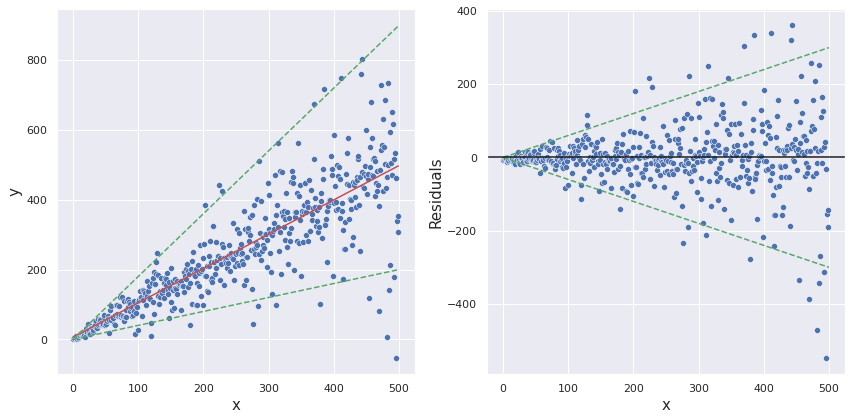

In [623]:

def generate_data( size: int, bounds: (0, 1000) ):
    X = np.arange(bounds[0], size)
    sd_deviation = np.random.uniform(0, (X/2)+4, size=size) + (X / 50)
    error = np.random.normal(0, sd_deviation, size=size)
    y = error + X
    return np.arange(0, len(y),1), y

x, y = generate_data(500, (0,1000))
data = pd.DataFrame.from_dict({'y':y,'x':x})

model = LinearRegression()
model.fit(data[['x']], data[['y']])
data['Predictions'] = model.predict(data[['x']])
data['Residuals'] = data['y'] - data['Predictions']

fig, ax = plt.subplots(1,2)
sns.scatterplot(x=data['x'], y=data['y'], ax=ax[0])
sns.lineplot(x=data['x'], y=data['Predictions'], color='r', ax=ax[0])
sns.scatterplot(x=data['x'], y=data['Residuals'], ax=ax[1])
ax[0].plot([0, 500], [0, 200], ls="--", color="g")
ax[0].plot([0, 500], [0, 900], ls="--", c="g")

ax[1].plot([0, 500], [0, 300], ls="--", color="g")
ax[1].plot([0, 500], [0, -300], ls="--", c="g")

ax[1].axhline(0, color='k')
plt.tight_layout()

This problem can also be fixed by transforming the values

A transformation of the y-variables may produce a homoscedastic scatter, i.e. result in equal spread of the residuals accross $x$. (However, it may also result in a non-linear scatter, which may require a second transformation of the x-values to fix!)

The scatter below shows the votes that Bush got versus those that Buchanan got. Just looking at the scatter, It seems that it's roughly linear, but when we look at the residual plot on the right hand side, we see that it's heteroscedastic.

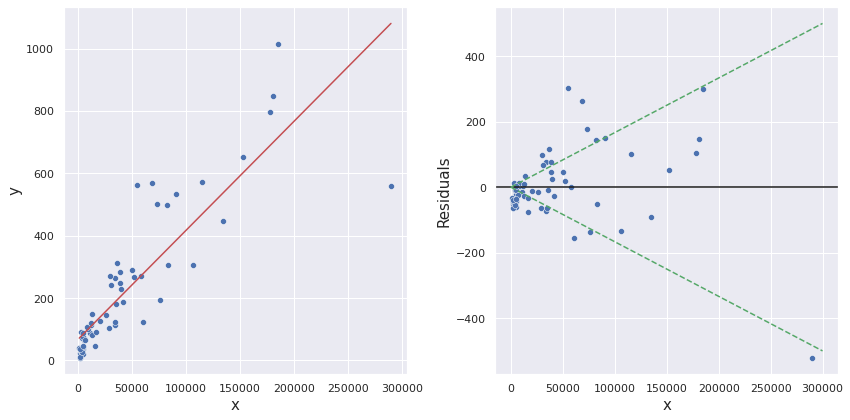

In [900]:

# Import data
election_us = pd.read_csv('../data/us_2000_election.csv')
election_florida = election[election['STATE'] == 'Florida']

# Filter candidates of interest
candidates = election_florida[['COUNTY', 'BUSH', 'BUCHANAN']].copy()
candidates.loc[:, 'BUCHANAN'] = candidates.loc[:, 'BUCHANAN'].astype(int)

# Exclude 'Palm Beach' county
candidates = candidates[candidates['COUNTY'] != "Palm Beach"]

# Cleaned data
data = pd.DataFrame({'x':candidates['BUSH'], 'y':candidates['BUCHANAN']})

# Modeling
model = LinearRegression()
model.fit(data[['x']], data[['y']])
data['Predictions'] = model.predict(data[['x']])
data['Residuals'] = data['y'] - data['Predictions']

# Plot regression and residuals
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=data['x'], y=data['y'], ax=ax[0])
sns.lineplot(x=data['x'], y=data['Predictions'], color='r', ax=ax[0])
sns.scatterplot(x=data['x'], y=data['Residuals'], ax=ax[1])
ax[1].axhline(0, color='k')

ax[1].plot([0, 300000], [0, 500], ls="--", color="g")
ax[1].plot([0, 300000], [0, -500], ls="--", c="g")
plt.tight_layout()

However, if we take logs of both variables, we get a result that looks quite satisfactory. 

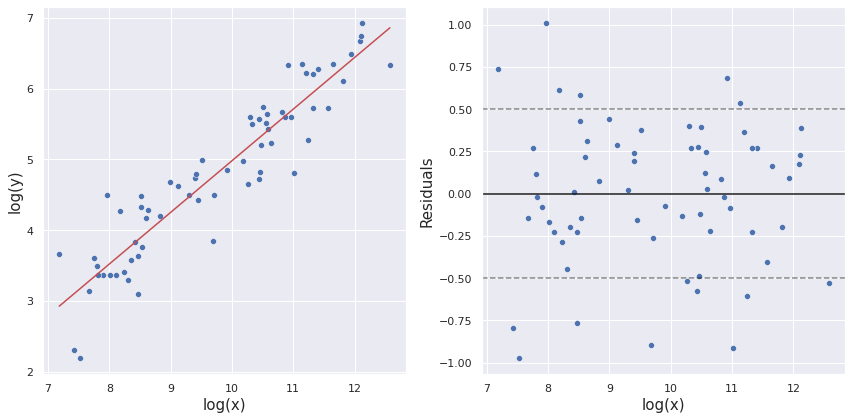

In [902]:

# Cleaned data
data = np.log(pd.DataFrame({'x':candidates['BUSH'], 'y':candidates['BUCHANAN']}))

# Modeling
model = LinearRegression()
model.fit(data[['x']], data[['y']])
data['Predictions'] = model.predict(data[['x']])
data['Residuals'] = data['y'] - data['Predictions']

# Plot regression and residuals
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=data['x'], y=data['y'], ax=ax[0])
sns.lineplot(x=data['x'], y=data['Predictions'], color='r', ax=ax[0])
sns.scatterplot(x=data['x'], y=data['Residuals'], ax=ax[1])
ax[1].axhline(0, color='k')
ax[0].set_ylabel('log(y)')
ax[0].set_xlabel('log(x)')
ax[1].set_xlabel('log(x)')
ax[1].axhline(0.50, color='k', linestyle="--", alpha=0.5)
ax[1].axhline(-0.50, color='k', linestyle="--", alpha=0.5)
plt.tight_layout()

In particular, notice when looking at a residual plot, we get a horizontal band that doesn't show any structure.